In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/steam-reviews-test-dataset/test.csv
/kaggle/input/steam-reviews/train.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score 
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import warnings
np.random.seed(123)
warnings.filterwarnings('ignore')
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Evolution of NLP - Part 3 - Transfer Learning using ULMFit

This is the third part of a series of posts showing the improvements in NLP modeling approaches. We have seen the use of traditional techniques like Bag of Words, TF-IDF, then moved on to RNNs and LSTMs. This time we'll look into one of the pivotal shifts in approaching NLP Tasks - Transfer Learning!

# ULMFit

The idea of using Transfer Learning is quite new in NLP Tasks, while it has been quite prominently used in Computer Vision tasks! This new way of looking at NLP was first proposed by Howard Jeremy, and has transformed the way we looked at data proviously!

The core idea is two-fold - using generative pretrained Language Model + task-specific fine-tuning was first explored in ULMFiT (Howard & Ruder, 2018), directly motivated by the success of using ImageNet pre-training for computer vision tasks. The base model is AWD-LSTM.

A Language Model is exactly like it sounds - the output of this model is to predict the next word of a sentence. The goal is to have a model which can understand the semantics, grammer and unique structure of a language.

**ULMFiT** follows three steps to achieve good transfer learning results on downstream language classification tasks:

1) General Language Model pre-training: on Wikipedia text.

2) Target task Language Model fine-tuning: ULMFiT proposed two training techniques for stabilizing the fine-tuning process.

3) Target task classifier fine-tuning: The pretrained LM is augmented with two standard feed-forward layers and a softmax normalization at the end to predict a target label distribution.

# Using fast.ai for NLP -

**fast.ai**'s motto - Making Neural Networks Uncool again - tells you a lot about their approach ;) Implementation of these models is remarkably simple and intuitive, and with good documentation, you can easily find a solution if you get stuck anywhere. Along with this, and few other reasons I elaborate below, I decided to try out fast.ai library which is build on top of PyTorch instead of Keras. Despite being used to working in Keras, I didn't find it difficult to navigate fast.ai and the learning curve is quite fast to implement advanced things as well!

In addition to it's simplicity, there are some advantages of using fast.ai's implementation -

* **Discriminative fine-tuning** is motivated by the fact that different layers of LM capture different types of information (see discussion above). ULMFiT proposed to tune each layer with different learning rates, {η1,…,ηℓ,…,ηL}, where η is the base learning rate for the first layer, ηℓ is for the ℓ-th layer and there are L layers in total.

* **Slanted triangular learning rates (STLR)** refer to a special learning rate scheduling that first linearly increases the learning rate and then linearly decays it. The increase stage is short so that the model can converge to a parameter space suitable for the task fast, while the decay period is long allowing for better fine-tuning

Let's try to see how well this approach works for our dataset. I would also like to point out that all these ideas and code are available at fast.ai's free official course for NLP - "".

In [3]:
train_dataset = pd.read_csv("/kaggle/input/steam-reviews/train.csv", delimiter=",")
train_dataset

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1
...,...,...,...,...,...
17489,25535,EverQuest II,2012.0,Arguably the single greatest mmorp that exists...,1
17490,25536,EverQuest II,2017.0,"An older game, to be sure, but has its own cha...",1
17491,25537,EverQuest II,2011.0,When I frist started playing Everquest 2 it wa...,1
17492,25538,EverQuest II,NaN,cool game. THe only thing that REALLY PISSES M...,1


In [4]:
test_dataset = pd.read_csv("/kaggle/input/steam-reviews-test-dataset/test.csv", delimiter=",")
test_dataset['user_suggestion'] = None

In [5]:
dataset = pd.concat([train_dataset, test_dataset], axis = 0)
dataset.reset_index(drop = True, inplace = True)
dataset

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1
...,...,...,...,...,...
25534,25198,GUNS UP!,2017.0,Early Access ReviewGuns UP!Positive: Good Idea...,None
25535,25199,GUNS UP!,2018.0,"After 170 hrs, my review. DO NOT SPEND ANY MON...",None
25536,25200,GUNS UP!,2018.0,Pros:-Fun GameplayCons: -Micro %$#*ing transac...,None
25537,25201,GUNS UP!,2018.0,"Actualy saucy, I definetly suggest to players ...",None


In [6]:
from matplotlib import pyplot as plt
import seaborn as sns

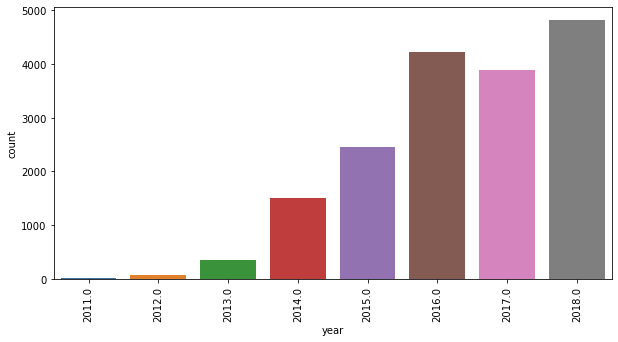

In [7]:
# Visualizing the variable - 'year'
plt.figure(figsize = (10,5))
plt.xticks(rotation=90)
sns.countplot(train_dataset['year'])

In [8]:
from fastai.text import *

In [9]:
from pathlib import Path

In [10]:
path = Path('/kaggle/input/steam-reviews/')

Data in fast.ai is taken using TextLMDataBunch. This is very similar to ImageGenerator in Keras, where the path, labels, etc. are provided and the method prepares Train, Test and Validation data depending on the task at hand!

## Data Bunch for Language Model

In [11]:
%%time
data_lm = TextLMDataBunch.from_csv(path,'train.csv', text_cols = 3, label_cols = 4)

CPU times: user 2.42 s, sys: 352 ms, total: 2.78 s
Wall time: 29.5 s


## Data Bunch for Classification Task

In [12]:
%%time
data_clas = TextClasDataBunch.from_csv(path, 'train.csv', vocab=data_lm.train_ds.vocab, bs=32, text_cols = 3, label_cols = 4)

CPU times: user 3.51 s, sys: 361 ms, total: 3.87 s
Wall time: 30.8 s


In [13]:
data_clas

TextClasDataBunch;

Train: LabelList (13995 items)
x: TextList
xxbos i was introduced by a former - friend and guide on this game , and i really enjoyed it . xxmaj it 's very time consuming , and i 've never been too much into xxup rpg 's , but this one was a lot of fun . 7 / 10,xxbos xxmaj if you 've ever played and enjoyed xxmaj starwars : xxmaj battlefront in your nostalgic childhood days , then planetside 2 may very well be in your ball park , and will knock several home runs to boot . xxmaj it will blow your ideas of massive scale battles in a video game out of the water , xxunk only by a few select titles . xxmaj soon upon entry you will learn that as a singular soldier your affect on the waging war is minuet at best , but your duty as an individual in a faction is as important as the people fighting by your side . planetside 2 is a game best played when working with others , or simply causing havoc with your friends . xxmaj there 's no feeling that can compare to flying well abo

In [14]:
bs=16

In [15]:
#torch.cuda.set_device(1)
#torch.cuda.set_device(0)

### Step 1. Training a Language Model

In [16]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [17]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.298730,4.067280,0.267849,01:20


### Discrimiative Fine-Tuning

*learn.unfreeze()* makes all the layers of AWD_LSTM trainable. We can set a training rate using slice() function, which trains the last layer at 1e-02, while groups (of layers) in between would have geometrically reducing learning rates.

### Slated Triangular Learning Rates

This can achieved simply by using fit_one_cycle() method in fast.ai

### Gradual Unfreezing

Though I've not experimented with this here, the idea is pretty simple. In the start we keep the initial layers of model as un-trainable, and then we slowly unfreeze earlier layers, as we keep on training. I'll cover this in detail in next post

In [18]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-4,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,4.069969,3.966954,0.278658,01:35
1,3.847313,3.836698,0.291688,01:35
2,3.581468,3.808362,0.296066,01:35


In [19]:
learn.predict("This is a review about", n_words=10)

'This is a review about the Game ..... You probably go'

In [20]:
learn.predict("This game is one of the ", n_words=10)

"This game is one of the  worst ♥♥♥♥♥ gamesgamesgamesgamesgames iiiii 've've've've've evereverevereverever playedplayedplayedplayedplayed ....."

This performs pretty well in predicting the next few words of the review. Time to save this and try it on our classification task.

In [21]:
learn.model_dir = Path('/kaggle/working/')

In [22]:
learn.save(file = Path('language_model'))
learn.save_encoder(Path('language_model_encoder'))

### Step 2. Classification Task using Language Model as encoder

In [23]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5).to_fp16()
learn.model_dir = Path('/kaggle/working/')
learn.load_encoder('language_model_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (13995 items)
x: TextList
xxbos i was introduced by a former - friend and guide on this game , and i really enjoyed it . xxmaj it 's very time consuming , and i 've never been too much into xxup rpg 's , but this one was a lot of fun . 7 / 10,xxbos xxmaj if you 've ever played and enjoyed xxmaj starwars : xxmaj battlefront in your nostalgic childhood days , then planetside 2 may very well be in your ball park , and will knock several home runs to boot . xxmaj it will blow your ideas of massive scale battles in a video game out of the water , xxunk only by a few select titles . xxmaj soon upon entry you will learn that as a singular soldier your affect on the waging war is minuet at best , but your duty as an individual in a faction is as important as the people fighting by your side . planetside 2 is a game best played when working with others , or simply causing havoc with your friends . xxmaj there 's no feeling that can compare to

In [24]:
data_clas.show_batch()

text,target
"xxbos i 'll give a thumbs up only because the game itself is pretty good , but this is not an actual review , it ’s more like a short summary about my over 900 hours spent into this game ( xxup lol n00b ca n’t write xxrep 4 ♥ until 2kh xxup noob ) . i started playing it because my friends convinced me , and because almost everybody",1
"xxbos 19 / xxunk / 17 ' : xxmaj game is pretty much still the same , with some extra features here and there but most of the review remains untouched . xxmaj it 's a shame - and if cod ww2 really is ' back to the roots ' this game might struggle . xxmaj this is xxup not an xxup ea title anymore ; the game you see",0
"xxbos xxmaj it ’s not so much the gameplay that is challenging , but your knowledge of the game itself that challenges you . xxmaj there are many nuances in the game that you have to learn . xxmaj first the vocabulary . xxmaj for example : "" 5 % increased damage "" is very different from "" 5 % more damage "" . xxmaj and because of this do",0
xxbos i purchased this game back and 2008 and only played the 30 day free trial but did nt feel like it was worth the subscription fee at the time as i probably did nt put enough time into . xxmaj when everquest 2 extended came out i downloaded it too but never ended up really playing it as i just could nt get into it . xxmaj finally i,1
"xxbos xxmaj early xxmaj access xxunk to all known xxunk aviation , there is no way a xxunk be able to fly . xxmaj its wings are too small to xxunk fat little body off the ground . xxmaj the bee , of course , flies xxunk bees do n't xxunk humans think is impossible . xxmaj yellow , black . xxmaj yellow , black . xxmaj yellow , black",1


In [25]:
learn.fit_one_cycle(1, 5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.395847,0.338423,0.858245,00:42


In [26]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.325072,0.284241,0.876536,01:59
1,0.262473,0.246284,0.896542,01:37
2,0.162163,0.263654,0.899971,01:55


In [27]:
learn.predict('This game is absolute shit! Dont waste your money!')

(Category tensor(0), tensor(0), tensor([0.9982, 0.0018]))

In [28]:
learn.predict('This is one of the best games to buy!')

(Category tensor(1), tensor(1), tensor([0.0525, 0.9475]))

In [29]:
learn.predict('The best button of the game is exit button')

(Category tensor(1), tensor(1), tensor([0.0289, 0.9711]))

Pretty good for the first two! But our model interestingly still can't tell the difference between appreciation and sarcasm! Maybe we can address this ove

In [30]:
#learn.unfreeze()
#learn.fit_one_cycle(3, slice(1e-4, 1e-2))

### **Accuracy - 90%**

It's amazing how little effort we had to put in to get to this point. fast.ai's implementation and ULMFit makes it incredible easy to get started with limited data and get great results, leveraging the power of Transfer Learning. I hope this was helpful for you as well to get started with NLP and Transfer Learning. I'll catch you later in the 4th blog of this series, where we take this up a notch and explore transformers!

In [31]:
data_clas.save('/kaggle/working/data_textlist_class')

In [32]:
learn.model_dir = Path('/kaggle/working/')
learn.save('data_model')

In [33]:
data_clas = load_data(path, '/kaggle/working/data_textlist_class', bs=bs, num_workers=1)

In [34]:
data_clas

TextClasDataBunch;

Train: LabelList (13995 items)
x: TextList
xxbos i was introduced by a former - friend and guide on this game , and i really enjoyed it . xxmaj it 's very time consuming , and i 've never been too much into xxup rpg 's , but this one was a lot of fun . 7 / 10,xxbos xxmaj if you 've ever played and enjoyed xxmaj starwars : xxmaj battlefront in your nostalgic childhood days , then planetside 2 may very well be in your ball park , and will knock several home runs to boot . xxmaj it will blow your ideas of massive scale battles in a video game out of the water , xxunk only by a few select titles . xxmaj soon upon entry you will learn that as a singular soldier your affect on the waging war is minuet at best , but your duty as an individual in a faction is as important as the people fighting by your side . planetside 2 is a game best played when working with others , or simply causing havoc with your friends . xxmaj there 's no feeling that can compare to flying well abo

In [35]:
data_clas = load_data(path, '/kaggle/working/data_textlist_class', bs=bs, num_workers=1)
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics = [accuracy]).to_fp16()
learn_c.model_dir = Path('/kaggle/working/')
learn_c.load('data_model', purge=False);

Loading and training on reverse data

In [36]:
data_clas_bwd = load_data(path, '/kaggle/working/data_textlist_class', bs=bs, num_workers=1, backwards=True)
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, metrics=[accuracy]).to_fp16()

In [37]:
data_clas_bwd.show_batch()

text,target
"scum trench n00b gud git lul xxunk a lose me xxup made you xxup because you kill to want xxunk silly xxmaj . videogame a lost i because only brother my kill to want n't do i course of , xxunk xxup > > ? ? ? videogame a lost you because just brother your kill to want really you do xxmaj ! dave xxmaj but - b < <",1
". ) mind in such and ribbons taking when ( unlock to lot a xxunk decent with f2p xxup xxunk has still it overal but ; performance over visuals reduces which slider extra an added they : gameplay unoptimized - / xxunk ) + ( now of as variety more has it , vehicles more add did they - ) imo enough not - vehicles and weapons in variety little",0
"d&d. xxup to related anything or nwn xxup after named n't was it if perspective different a from it at look probably would i . matter that for , fun or , playable n't is game this say to n't is that xxmaj . this in disappointed utterly be to going are players of kinds those of both xxmaj . fans nights xxmaj neverwinter xxmaj nor , fans d&d xxup",0
") war the of vehicles with mean i ( itself school than teacher better a definitely is it as , games of type these with familiar not those even to game this recomment i , overall xxmaj ) permanently it get you , with lions xxmaj silver xxmaj and points research of lot a earn can you that , vehicle exclusive ( vehicle premium a purchase or ) battles from",1
". you see xxmaj . day some product optimised and decent a us give to able be will ed xxup hope let and continuation great a guy you hope i anyway xxmaj . saw we what from far really is game the and demos and videos promo saw all we , too dissapointed be will you or setup gen last very have you unless improvement for wait and one this",0


In [38]:
learn_c_bwd.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.679354,0.681688,0.575593,01:35


In [39]:
learn_c_bwd.unfreeze()
learn_c_bwd.fit_one_cycle(5, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.512702,0.473597,0.780223,03:29
1,0.428858,0.415033,0.825379,02:47
2,0.361522,0.358077,0.855387,03:35
3,0.283403,0.346236,0.856245,03:01
4,0.246624,0.331362,0.863675,03:18


In [40]:
preds,targs = learn_c.get_preds(ordered=True)
accuracy(preds,targs)

tensor(0.9000)

In [41]:
preds_b,targs_b = learn_c_bwd.get_preds(ordered=True)
accuracy(preds_b,targs_b)

tensor(0.8637)

In [42]:
preds_avg = (preds+preds_b)/2
accuracy(preds_avg,targs_b)

tensor(0.9003)